In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.cluster import KMeans
from gp_extras.kernels import HeteroscedasticKernel

np.random.seed(0)


import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

file_path = "/Users/ndas/Documents/Semiconductor/Cbd vs Stress Volatge data.xlsx"

# Function to read data from an Excel file
def read_excel_data(file_path):
    # Load the Excel file
    data = pd.read_excel(file_path, header=None)  # Read without assuming any headers
    # Extract Stress Voltage and Cycles to Breakdown
    stress_voltage = data.iloc[
        0, 1:
    ].to_numpy()  # First row, excluding the first column
    cycles_to_breakdown = data.iloc[
        1, 1:
    ].to_numpy()  # Second row, excluding the first column

    return stress_voltage, cycles_to_breakdown
try:
    x, y = read_excel_data(file_path)
    print("Stress Voltage (x):", x)
    print("Cycles to Breakdown (y):", y)
except Exception as e:
    print("Error:", e)
y = -np.log10(y.astype(float))
X = x.astype(float)

In [ ]:
# Gaussian Process with RBF kernel and homoscedastic noise level
kernel_homo = C(1.0, (1e-10, 1000)) * RBF(1, (0.01, 100.0)) \
    + WhiteKernel(1e-3, (1e-10, 50.0))
gp_homoscedastic = GaussianProcessRegressor(kernel=kernel_homo, alpha=0)
gp_homoscedastic.fit(X[:, np.newaxis], y)
print("Homoscedastic kernel: %s" % gp_homoscedastic.kernel_)
print("Homoscedastic LML: %.3f" \
    % gp_homoscedastic.log_marginal_likelihood(gp_homoscedastic.kernel_.theta))

# Gaussian Process with RBF kernel and heteroscedastic noise level
prototypes = KMeans(n_clusters=9).fit(X[:, np.newaxis]).cluster_centers_
kernel_hetero = C(1.0, (1e-10, 1000)) * RBF(
    1, (0.01, 100.0)
) + HeteroscedasticKernel.construct(
    prototypes, 1e-3, (1e-10, 100.0), gamma=5.0, gamma_bounds="fixed"
)


gp_heteroscedastic = GaussianProcessRegressor(
    kernel=kernel_hetero, alpha=0, optimizer="fmin_l_bfgs_b"
)
gp_heteroscedastic.fit(X[:, np.newaxis], y)
print("Heteroscedastic kernel: %s" % gp_heteroscedastic.kernel_)
print("Heteroscedastic LML: %.3f" % gp_heteroscedastic.log_marginal_likelihood(gp_heteroscedastic.kernel_.theta))

In [ ]:

# Plot result
X_ = np.linspace(1, 3, 100)
# y_ = X_
# noise_std = 0.5 * X_

plt.subplot(1, 2, 1)
plt.scatter(X, y)
# plt.plot(X_, y_, 'b', label="true function")
# plt.fill_between(X_, y_ - noise_std, y_ + noise_std,alpha=0.5, color='b')
y_mean, y_std = gp_homoscedastic.predict(X_[:, None], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9, label="predicted mean")
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,alpha=0.5, color='k')
plt.xlim(1, 3)
plt.legend(loc="best")
plt.title("Homoscedastic noise model")

plt.subplot(1, 2, 2)
plt.scatter(X, y)
# plt.plot(X_, y_, 'b', label="true function")
# plt.fill_between(X_, y_ - noise_std, y_ + noise_std,alpha=0.5, color='b')
y_mean, y_std = gp_heteroscedastic.predict(X_[:, None], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9, label="predicted mean")
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,alpha=0.5, color='k')
plt.xlim(1, 3)
plt.legend(loc="best")
plt.title("Heteroscedastic noise model")
plt.show()

Stress Voltage (x): [np.float64(2.14) np.float64(2.42) np.float64(2.49) np.float64(2.66)
 np.float64(2.7922) np.float64(2.8) np.float64(2.9) np.float64(2.9572)
 np.float64(2.96)]
Cycles to Breakdown (y): [np.float64(10000000.0) np.float64(500000.0) np.float64(300000.0)
 np.float64(30000.0) np.float64(5000.0) np.float64(7000.0)
 np.float64(1000.0) np.float64(300.0) np.float64(100.0)]


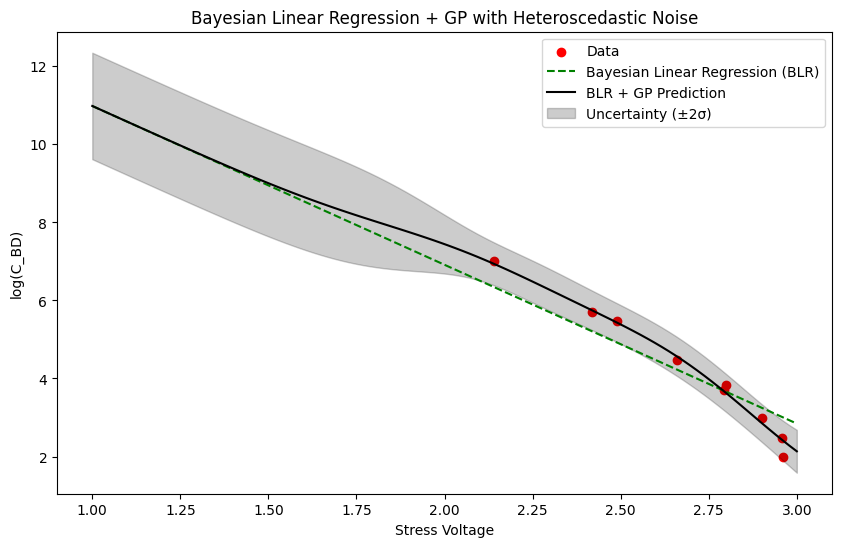

BLR Weights (Posterior Mean): [15.05431634 -4.07027992]
BLR Posterior Covariance:
 [[20.98267479 -7.75158631]
 [-7.75158631  2.90010323]]
GP Kernel After Fitting:
 0.659**2 * RBF(length_scale=0.29) + HeteroscedasticKernel(sigma_2=[0.0191, 0.0226, 0.0192, 0.0334, 0.0254, 0.0432, 0.0806, 0.0833, 0.0833], gamma=0.059592593053621606)


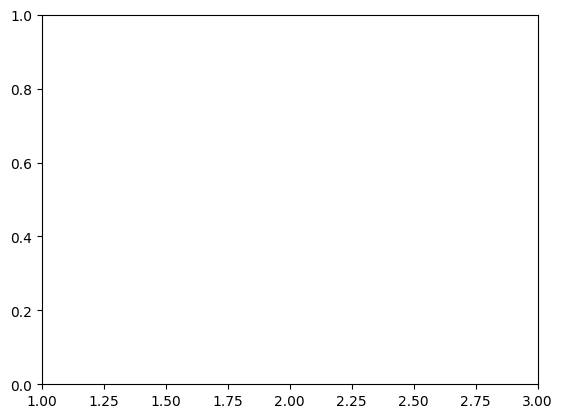

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from gp_extras.kernels import HeteroscedasticKernel
from scipy.linalg import inv
import pandas as pd
from sklearn.cluster import KMeans
from gp_extras.kernels import HeteroscedasticKernel
import warnings
from sklearn.exceptions import ConvergenceWarning
np.random.seed(42)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
file_path = "/Users/ndas/Documents/Semiconductor/Cbd vs Stress Volatge data.xlsx"

# Function to read data from an Excel file
def read_excel_data(file_path):
    data = pd.read_excel(file_path, header=None)  # Read without assuming any headers
    stress_voltage = data.iloc[
        0, 1:
    ].to_numpy()  # First row, excluding the first column
    cycles_to_breakdown = data.iloc[
        1, 1:
    ].to_numpy()  # Second row, excluding the first column
    return stress_voltage, cycles_to_breakdown
try:
    x, y = read_excel_data(file_path)
    print("Stress Voltage (x):", x)
    print("Cycles to Breakdown (y):", y)
except Exception as e:
    print("Error:", e)
y = np.log10(y.astype(float))
X = x.astype(float)

phi_X = np.vstack((np.ones_like(X), X)).T  # Basis functions: [1, x]

# Bayesian Linear Regression (Prior)
alpha = 0.01  # Prior precision, typically smaller values (0.01, 0.1, etc.)
# beta = 1 / 4**2  # Noise precision (1/noise variance)
beta = 1 / np.var(y)  # A better initial guess for beta

Lambda_0 = alpha * np.eye(2)  # Prior covariance
mu_0 = np.zeros(2)  # Prior mean

# Compute posterior of BLR
S_N_inv = Lambda_0 + beta * phi_X.T @ phi_X
S_N = inv(S_N_inv)
m_N = S_N @ (Lambda_0 @ mu_0 + beta * phi_X.T @ y)

# Residuals for GP
y_pred_blr = phi_X @ m_N  # BLR prediction
residuals = y - y_pred_blr

# GP for heteroscedastic noise
prototypes = X[:, np.newaxis]  # Using all points as prototypes
kernel = C(1.0, (1e-4, 1e3)) * RBF(
    length_scale=1.0, length_scale_bounds=(1e-2, 1e2)
) + HeteroscedasticKernel.construct(
    prototypes, 1.0, (1e-4, 50.0), gamma=1.0
)  # Reduced gamma

gp = GaussianProcessRegressor(kernel=kernel, alpha=0)
gp.fit(X[:, np.newaxis], residuals)

# Predictions
X_ = np.linspace(1, 3, 100)
phi_X_ = np.vstack((np.ones_like(X_), X_)).T
y_pred_blr_ = phi_X_ @ m_N
gp_mean, gp_std = gp.predict(X_[:, np.newaxis], return_std=True)
y_pred = y_pred_blr_ + gp_mean

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="r", label="Data")
plt.plot(X_, y_pred_blr_, "g--", label="Bayesian Linear Regression (BLR)")
plt.plot(X_, y_pred, "k-", label="BLR + GP Prediction")
plt.fill_between(
    X_,
    y_pred - 2 * gp_std,
    y_pred + 2 * gp_std,
    color="k",
    alpha=0.2,
    label="Uncertainty (±2σ)",
)
plt.legend(loc="best")
plt.xlabel("Stress Voltage")
plt.ylabel("log(C_BD)")

plt.title("Bayesian Linear Regression + GP with Heteroscedastic Noise")
plt.savefig(
    "high_def_plot_uq.png", dpi=600, bbox_inches="tight", format="png"
)  # Change 'png' to 'pdf' or 'svg' for vector graphics

plt.show()
plt.xlim([1,3])
# Print BLR weights
print("BLR Weights (Posterior Mean):", m_N)
print("BLR Posterior Covariance:\n", S_N)
print("GP Kernel After Fitting:\n", gp.kernel_)

In [ ]:
# Add a new x
x_min, x_max = x.min(), x.max()  # Get min and max of x
x_points = np.linspace(x_min, x_max, 10)  # Create 100 equally spaced points
# Gen y samples
t = 1
cost = []
for i in range(10):
    S_N = inv(S_N_inv)
    phi_X = np.vstack(
        (np.ones_like(x_points[i]), x_points[i])
    ).T  # Basis functions: [1, x]
    cov_blr = phi_X @S_N @ phi_X.T
    gp_mean, gp_std = gp.predict(np.array([x_points[i]]).reshape(-1,1), return_std=True)
    cost = np.append(cost,cov_blr**0.5 - t* gp_std)

# Plot Sigma vs x
plt.figure(figsize=(10, 6))
plt.plot(x_points, cost, label="Sigma (Variance)")
plt.xlabel("x (Stress Voltage)")
plt.ylabel("Sigma")
plt.title("Sigma vs x")
plt.legend()
plt.grid()
plt.show()

In [ ]:
for j in range(10):
    # Add a new x
    x_min, x_max = x.min(), x.max()  # Get min and max of x
    x_points = np.linspace(x_min, x_max, 10).astype(float)  # Create 100 equally spaced points
    # Gen y samples
    t = 1
    cost = []
    for i in range(10):
        S_N = inv(S_N_inv)
        phi_X = np.vstack(
            (np.ones_like(x_points[i]), x_points[i])
        ).T  # Basis functions: [1, x]
        cov_blr = phi_X @ S_N @ phi_X.T
        gp_mean, gp_std = gp.predict(
            np.array([x_points[i].item()]).reshape(-1, 1), return_std=True
        )
        cost = np.append(cost, cov_blr**0.5 - t * gp_std)
    min_index = np.argmin(cost)
    x_min_cost = x_points[min_index]
    # Use x_min_cost and estimate a y to be used in the next cycle
    # Predictions
    X_ = x_min_cost
    phi_X_ = np.vstack((np.ones_like(X_), X_)).T
    y_pred_blr_ = phi_X_ @ m_N
    gp_mean, gp_std = gp.predict(np.array([x_min_cost]).reshape(-1,1), return_std=True)
    y_pred = y_pred_blr_ + gp_mean
    # Add these two points and fit the BLR and GP again and predict the covariance at x = 1
    x = np.append(x, x_min_cost)
    y = np.append(y, y_pred)
    ##
    X = x
    print(type(X))
    phi_X = np.vstack((np.ones_like(X), X)).T  # Basis functions: [1, x]
    phi_X = np.array(phi_X, dtype=np.float64)
    # Bayesian Linear Regression (Prior)
    alpha = 0.01  # Prior precision, typically smaller values (0.01, 0.1, etc.)
    # beta = 1 / 4**2  # Noise precision (1/noise variance)
    beta = 1 / np.var(y)  # A better initial guess for beta
    Lambda_0 = alpha * np.eye(2)  # Prior covariance
    mu_0 = np.zeros(2)  # Prior mean
    # Compute posterior of BLR
    S_N_inv = Lambda_0 + beta * phi_X.T @ phi_X
    S_N_inv = np.array(S_N_inv, dtype=np.float64)
    # print(type(S_N_inv))
    # print(S_N_inv)

    S_N = inv(S_N_inv)
    m_N = S_N @ (Lambda_0 @ mu_0 + beta * phi_X.T @ y)
    # Residuals for GP
    y_pred_blr = phi_X @ m_N  # BLR prediction
    residuals = y - y_pred_blr
    # GP for heteroscedastic noise
    prototypes = X[:, np.newaxis]  # Using all points as prototypes
    kernel = C(1.0, (1e-4, 1e3)) * RBF(
        length_scale=1.0, length_scale_bounds=(1e-2, 1e2)
    ) + HeteroscedasticKernel.construct(
        prototypes, 1.0, (1e-4, 50.0), gamma=1.0
    )  # Reduced gamma

    gp = GaussianProcessRegressor(kernel=kernel, alpha=0)
    gp.fit(X[:, np.newaxis], residuals)
    # Predictions
    X_ = np.linspace(1, 3, 100)
    phi_X_ = np.vstack((np.ones_like(X_), X_)).T
    y_pred_blr_ = phi_X_ @ m_N
    gp_mean, gp_std = gp.predict(X_[:, np.newaxis], return_std=True)
    y_pred = y_pred_blr_ + gp_mean
##

<class 'numpy.ndarray'>


TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable sqrt method

Data saved to /Users/ndas/Documents/Semiconductor/Cbd_vs_Stress_Voltage_Data.csv
1.7029689454308072
[0.0448618]
1.7029689454308072
[0.01661872]
1.7029689454308072
[0.0197673]
1.7029689454308072
[0.03011051]
1.7029689454308072
[0.06301412]
1.7029689454308072
[0.08655354]
1.7029689454308072
[0.03804184]
1.7029689454308072
[0.06833452]
1.7029689454308072
[0.6255973]
1.7029689454308072
[0.63611106]


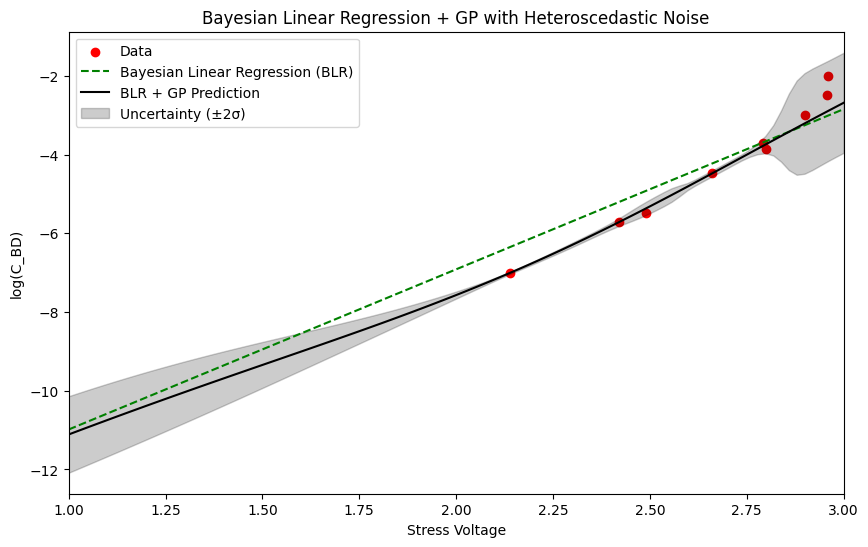

1.601845550736137
[0.07980049]
1.601845550736137
[0.02384034]
1.601845550736137
[0.05468313]
1.601845550736137
[0.11957304]
1.601845550736137
[0.11038182]
1.601845550736137
[0.09655871]
1.601845550736137
[0.17537382]
1.601845550736137
[0.26900437]
1.601845550736137
[0.37581978]
1.601845550736137
[0.4443254]


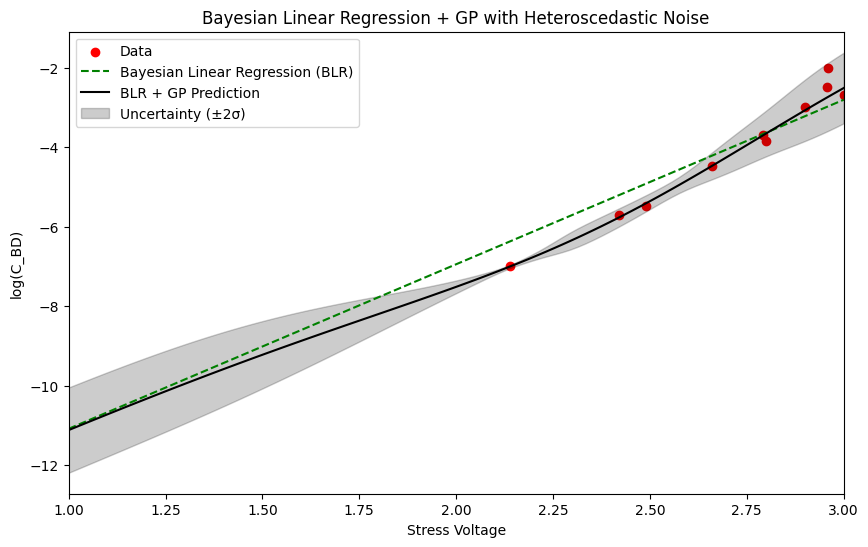

1.531310765503661
[0.10612552]
1.531310765503661
[0.07782833]
1.531310765503661
[0.07152997]
1.531310765503661
[0.15054492]
1.531310765503661
[0.12465838]
1.531310765503661
[0.06807864]
1.531310765503661
[0.0414906]
1.531310765503661
[0.09378096]
1.531310765503661
[0.576127]
1.531310765503661
[0.54338512]


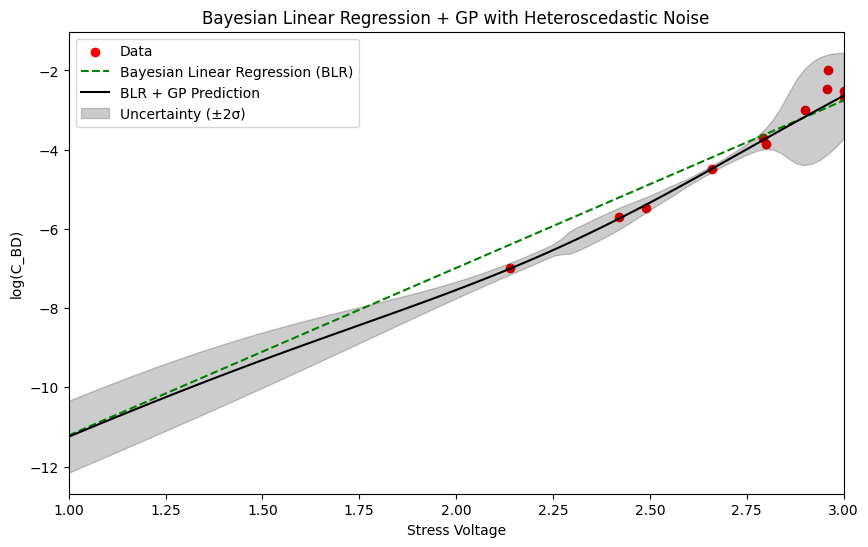

1.4712551513639605
[0.07108852]
1.4712551513639605
[0.02659542]
1.4712551513639605
[0.033905]
1.4712551513639605
[0.22295113]
1.4712551513639605
[0.17962487]
1.4712551513639605
[0.03980486]
1.4712551513639605
[0.02788389]
1.4712551513639605
[0.16435314]
1.4712551513639605
[0.28622753]
1.4712551513639605
[0.81214687]


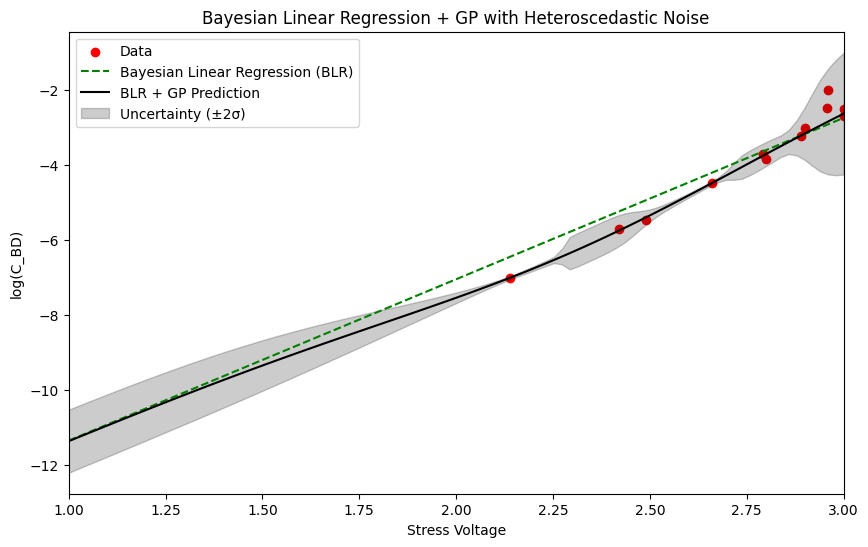

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from gp_extras.kernels import HeteroscedasticKernel
from scipy.linalg import inv
import pandas as pd
from sklearn.cluster import KMeans
from gp_extras.kernels import HeteroscedasticKernel
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

np.random.seed(42)

file_path = "/Users/ndas/Documents/Semiconductor/Cbd vs Stress Volatge data.xlsx"
output_file_path = "/Users/ndas/Documents/Semiconductor/Cbd_vs_Stress_Voltage_Data.csv"
output_file_path_pred_covat1 = "/Users/ndas/Documents/Semiconductor/covat1.csv"


def read_excel_data(file_path):
    data = pd.read_excel(file_path, header=None)  # Read without assuming any headers
    stress_voltage = data.iloc[
        0, 1:
    ].to_numpy()  # First row, excluding the first column
    cycles_to_breakdown = data.iloc[
        1, 1:
    ].to_numpy()  # Second row, excluding the first column
    return stress_voltage, cycles_to_breakdown
try:
    # Read the data
    x, y = read_excel_data(file_path)
    # Process the data
    y = -np.log10(y.astype(float))  # Apply -log10 transformation to y
    x = np.array(x.astype(float))  # Convert x to float
except Exception as e:
    print("Error:", e)

# Create a DataFrame and save the original data
data = pd.DataFrame({"Stress Voltage": x, "Cycles to Breakdown": y})
# Save to CSV
data.to_csv(output_file_path, index=False)
print(f"Data saved to {output_file_path}")

y_std_at_1 = []
for j in range(10):
    # Read the CSV file
    # data = pd.read_csv(output_file_path)
    # Extract columns into NumPy arrays
    x = data["Stress Voltage"].to_numpy()
    y = data["Cycles to Breakdown"].to_numpy()
    X = x
    phi_X = np.vstack((np.ones_like(X), X)).T  # Basis functions: [1, x]
    alpha = 0.01  # Prior precision, typically smaller values (0.01, 0.1, etc.)
    beta = 1 / np.var(y)  # A better initial guess for beta
    Lambda_0 = alpha * np.eye(2)  # Prior covariance
    mu_0 = np.zeros(2)  # Prior mean
    # Compute posterior of BLR
    S_N_inv = Lambda_0 + beta * phi_X.T @ phi_X
    S_N = inv(S_N_inv)
    m_N = S_N @ (Lambda_0 @ mu_0 + beta * phi_X.T @ y)
    # Residuals for GP
    y_pred_blr = phi_X @ m_N  # BLR prediction
    residuals = y - y_pred_blr
    # GP for heteroscedastic noise
    epsilon = 1e-5  # Regularization term to avoid singularity

    prototypes = X[:, np.newaxis]  # Using all points as prototypes
    kernel = (
        C(1.0, (1e-4, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
        + HeteroscedasticKernel.construct(prototypes, 1.0, (1e-4, 50.0), gamma=1.0)
        + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e1))  # Add white noise

    )  # Reduced gamma

    gp = GaussianProcessRegressor(
        kernel=kernel, alpha=0, n_restarts_optimizer=100
    )
    # gp.optimizer_kwargs = {"max_iter": 5000}
    gp.fit(X[:, np.newaxis], residuals)
    # Add a new x
    x_min, x_max = 2, 3  # Get min and max of x
    n_grid_pts = 10
    x_points = np.linspace(x_min, x_max, n_grid_pts)  # Create 100 equally spaced points
    # Gen y samples
    t = 1
    cost = []
    for i in range(n_grid_pts):
        S_N = inv(S_N_inv)
        phi_X = np.vstack(
            (np.ones_like(x_points[i]), x_points[i])
        ).T  # Basis functions: [1, x]
        # cov_blr = phi_X @ S_N @ phi_X.T
        cov_blr = S_N[1,1].item()
        gp_mean, gp_std = gp.predict(
            np.array([x_points[i]]).reshape(-1, 1), return_std=True
        )
        print(cov_blr**0.5)
        print(gp_std)
        cost = np.append(cost, cov_blr**0.5 - 0.2 * gp_std)
        min_index = np.argmin(cost)
    x_min_cost = x_points[min_index]
    # # Predictions
    phi_X_ = np.vstack((np.ones_like(x_min_cost), x_min_cost)).T
    y_pred_blr_ = phi_X_ @ m_N
    gp_mean, gp_std = gp.predict(x_min_cost.reshape(-1,1), return_std=True)
    y_pred = y_pred_blr_ + gp_mean

    # # Sample y instead of just using the mean
    # phi_X = np.vstack((np.ones_like(x_min_cost), x_min_cost)).T
    # y_sample_blr = np.random.normal(loc=phi_X_ @ m_N, scale=(phi_X @ S_N @ phi_X.T)**0.5, size=(1,1))
    # y_sample_GP = np.random.normal(loc=gp_mean, scale=gp_std, size=(1,1))
    # y_pred_tmp = y_sample_blr.item() + y_sample_GP.item()

    # print(x_min_cost)
    # print(y_pred.item())
    # Add new data points
    data.loc[len(data)] = [x_min_cost, y_pred.item()]

    # # Predictions at x = 1
    phi_X_ = np.vstack((np.ones_like(1), 1)).T
    gp_mean, gp_std = gp.predict(np.array([1]).reshape(-1, 1), return_std=True)
    cov_blr = phi_X @ S_N @ phi_X.T
    # print(cov_blr[0]**0.5)
    # print(gp_std)
    # y_std_at_1 = np.append(y_std_at_1,(cov_blr[0]**0.5).item())
    y_std_at_1 = np.append(y_std_at_1, (gp_std).item())

    # Predictions
    X_ = np.linspace(1, 3, 100)
    phi_X_ = np.vstack((np.ones_like(X_), X_)).T
    y_pred_blr_ = phi_X_ @ m_N
    gp_mean, gp_std = gp.predict(X_[:, np.newaxis], return_std=True)
    y_pred = y_pred_blr_ + gp_mean

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color="r", label="Data")
    plt.plot(X_, y_pred_blr_, "g--", label="Bayesian Linear Regression (BLR)")
    plt.plot(X_, y_pred, "k-", label="BLR + GP Prediction")
    plt.fill_between(
        X_,
        y_pred - 2 * gp_std,
        y_pred + 2 * gp_std,
        color="k",
        alpha=0.2,
        label="Uncertainty (±2σ)",
    )
    plt.legend(loc="best")
    plt.xlabel("Stress Voltage")
    plt.ylabel("log(C_BD)")
    plt.xlim([1, 3])
    plt.title("Bayesian Linear Regression + GP with Heteroscedastic Noise")
    # plt.savefig(
    #     "high_def_plot_uq.png", dpi=600, bbox_inches="tight", format="png"
    # )  # Change 'png' to 'pdf' or 'svg' for vector graphics
    plt.show()


# Save to CSV
data.to_csv(output_file_path, index=False)
print(f"Data saved to {output_file_path}")
# Convert to DataFrame
# # Convert arrays into a DataFrame
# df = pd.DataFrame({"Array1": array1, "Array2": array2})

# # Save to CSV
# df.to_csv("combined_data.csv", index=False)

# # Save to CSV
# df.to_csv("data.csv", index=False)
# output_file_path_pred_covat1

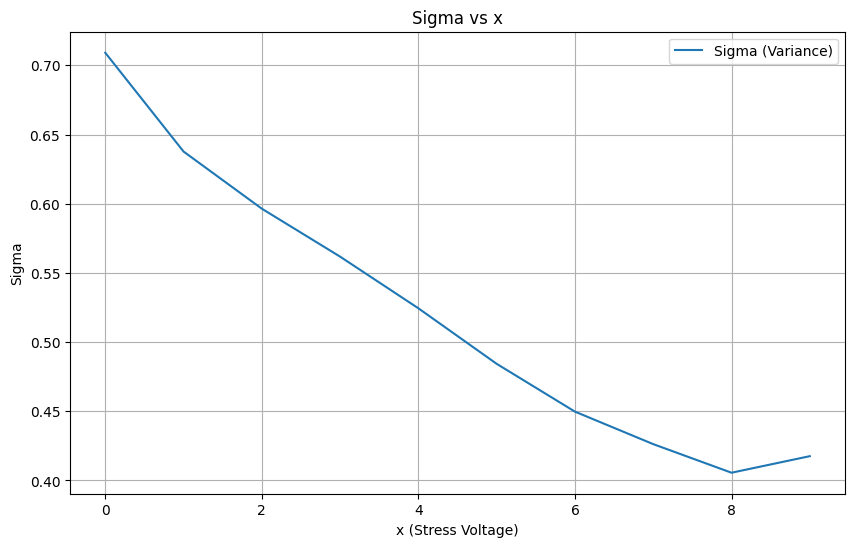

In [13]:
# Plot Sigma vs x
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_std_at_1)), y_std_at_1, label="Sigma (Variance)")
plt.xlabel("x (Stress Voltage)")
plt.ylabel("Sigma")
plt.title("Sigma vs x")
plt.legend()
plt.grid()
plt.show()

In [4]:
y_std_at_1

array([1.40323715, 1.11900044,        nan,        nan, 0.83446825,
              nan,        nan, 0.76703898,        nan, 0.70889424])